# 1. Importação das Bibliotecas

Importando tudo o que precisa: numpy para carregar os dados, pandas para o gráfico, matplotlib para visualização, os modelos e métricas do sklearn, e o BayesSearchCV do scikit-optimize (skopt).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import time

# Configurações de visualização
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# 2. Carregamento dos Dados

Carregando os arquivos .npy que foi preparado nas etapas anteriores (treino balanceado com SMOTE e teste original).

In [6]:
try:
    X_train = np.load("/content/drive/My Drive/Colab Notebooks/PNS project/X_train_smote.npy", allow_pickle=True)
    y_train = np.load("/content/drive/My Drive/Colab Notebooks/PNS project/y_train_smote.npy", allow_pickle=True)
    X_test = np.load("/content/drive/My Drive/Colab Notebooks/PNS project/X_test_final.npy", allow_pickle=True)
    y_test = np.load("/content/drive/My Drive/Colab Notebooks/PNS project/y_test.npy", allow_pickle=True)

    print(f"Formato X_train: {X_train.shape}")
    print(f"Formato y_train: {y_train.shape}")
    print(f"Formato X_test: {X_test.shape}")
    print(f"Formato y_test: {y_test.shape}")

except FileNotFoundError:
    print("Erro: Verifique se os arquivos .npy estão no mesmo diretório do notebook.")

Formato X_train: (1320, 48)
Formato y_train: (1320,)
Formato X_test: (387, 48)
Formato y_test: (387,)


# 3. Definição dos Espaços de Busca (Hyperparameters)

Definir os intervalos que o BayesSearchCV irá explorar para cada modelo.

In [7]:
# Espaço de busca para KNN
search_space_knn = {
    'n_neighbors': Integer(3, 25),
    'weights': Categorical(['uniform', 'distance']),
    'metric': Categorical(['euclidean', 'manhattan', 'minkowski'])
}

# Espaço de busca para Decision Tree
search_space_dt = {
    'criterion': Categorical(['gini', 'entropy']),
    'max_depth': Integer(3, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20)
}

# Espaço de busca para Random Forest
search_space_rf = {
    'n_estimators': Integer(50, 300),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'criterion': Categorical(['gini', 'entropy'])
}

# 4. Configuração e Execução do BayesSearchCV

O `n_iter` define quantas combinações de hiperparâmetros serão testadas.
Estou usando `scoring='f1'` (bom para dados balanceados/desbalanceados) e `cv=5` (validação cruzada de 5 folds).

In [8]:
# Dicionário para armazenar os melhores modelos
best_models = {}

# --- Otimização KNN ---
print("Iniciando otimização do KNN...")
start_time = time.time()
bayes_knn = BayesSearchCV(
    KNeighborsClassifier(),
    search_space_knn,
    n_iter=30,
    cv=5,
    n_jobs=-1,  # Usar todos os processadores
    scoring='f1',
    random_state=42
)
bayes_knn.fit(X_train, y_train)
best_models['KNN'] = bayes_knn.best_estimator_
print(f"KNN otimizado em {time.time() - start_time:.2f}s")
print(f"Melhores parâmetros KNN: {bayes_knn.best_params_}\n")


# --- Otimização Decision Tree ---
print("Iniciando otimização da Decision Tree...")
start_time = time.time()
bayes_dt = BayesSearchCV(
    DecisionTreeClassifier(random_state=42),
    search_space_dt,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)
bayes_dt.fit(X_train, y_train)
best_models['Decision Tree'] = bayes_dt.best_estimator_
print(f"Decision Tree otimizada em {time.time() - start_time:.2f}s")
print(f"Melhores parâmetros DT: {bayes_dt.best_params_}\n")


# --- Otimização Random Forest ---
print("Iniciando otimização do Random Forest...")
start_time = time.time()
bayes_rf = BayesSearchCV(
    RandomForestClassifier(random_state=42),
    search_space_rf,
    n_iter=30,
    cv=5,
    n_jobs=-1,
    scoring='f1',
    random_state=42
)
bayes_rf.fit(X_train, y_train)
best_models['Random Forest'] = bayes_rf.best_estimator_
print(f"Random Forest otimizado em {time.time() - start_time:.2f}s")
print(f"Melhores parâmetros RF: {bayes_rf.best_params_}\n")

print("\nOtimização de todos os modelos concluída!")

Iniciando otimização do KNN...


/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(3), np.str_('distance')] before, using random point ['minkowski', np.int64(6), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(3), np.str_('distance')] before, using random point ['manhattan', np.int64(21), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(3), np.str_('distance')] before, using random point ['manhattan', np.int64(11), 'distance']
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('manhattan'), np.int64(3), np.str_('distance')] befor

KNN otimizado em 39.11s
Melhores parâmetros KNN: OrderedDict({'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'})

Iniciando otimização da Decision Tree...
Decision Tree otimizada em 39.96s
Melhores parâmetros DT: OrderedDict({'criterion': 'entropy', 'max_depth': 47, 'min_samples_leaf': 4, 'min_samples_split': 5})

Iniciando otimização do Random Forest...
Random Forest otimizado em 122.88s
Melhores parâmetros RF: OrderedDict({'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300})


Otimização de todos os modelos concluída!


# 5. Avaliação dos Modelos no Conjunto de Teste

Agora vou usar os *melhores modelos* encontrados para fazer previsões no conjunto de teste (X_test_final) e calcular as métricas.

In [9]:
results_list = []

for model_name, model in best_models.items():
    print(f"--- Avaliando: {model_name} ---")

    # Fazer previsões
    y_pred = model.predict(X_test)

    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Imprimir o relatório de classificação
    print(classification_report(y_test, y_pred))

    # Guardar resultados
    results_list.append({
        'Modelo': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

# Converter lista de resultados para DataFrame
df_results = pd.DataFrame(results_list)
df_results = df_results.set_index('Modelo')

print("\n--- DataFrame de Resultados ---")
print(df_results)

--- Avaliando: KNN ---
              precision    recall  f1-score   support

           1       0.48      0.66      0.56       103
           2       0.86      0.74      0.80       284

    accuracy                           0.72       387
   macro avg       0.67      0.70      0.68       387
weighted avg       0.76      0.72      0.73       387

--- Avaliando: Decision Tree ---
              precision    recall  f1-score   support

           1       0.70      0.74      0.72       103
           2       0.90      0.88      0.89       284

    accuracy                           0.84       387
   macro avg       0.80      0.81      0.81       387
weighted avg       0.85      0.84      0.85       387

--- Avaliando: Random Forest ---
              precision    recall  f1-score   support

           1       0.91      0.72      0.80       103
           2       0.91      0.98      0.94       284

    accuracy                           0.91       387
   macro avg       0.91      0.85      

# 6. Visualização Comparativa das Métricas

Finalmente, o gráfico de barras horizontal para comparar o desempenho dos modelos.

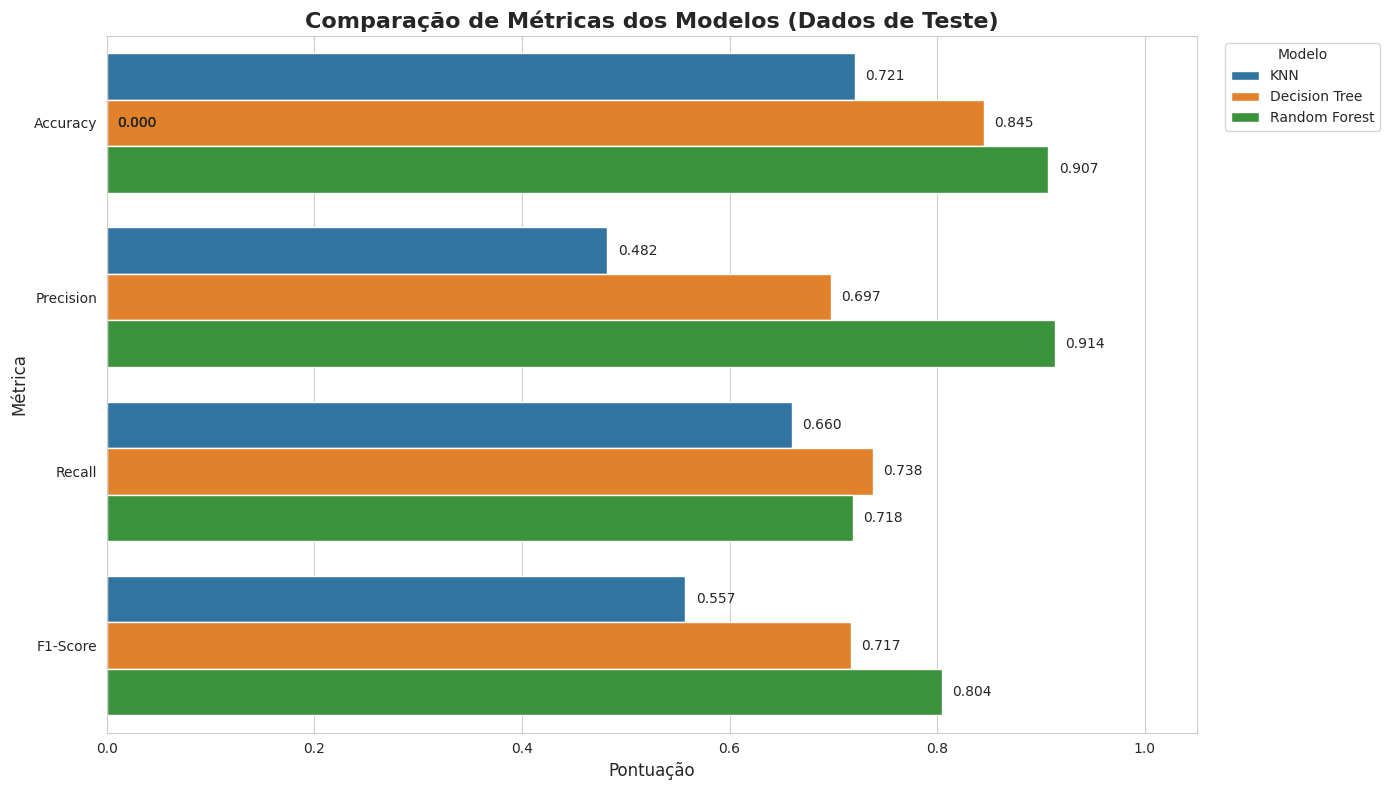

In [10]:
# Reformatando o DataFrame para facilitar o plot (melt)
df_plot = df_results.stack().reset_index()
df_plot.columns = ['Modelo', 'Métrica', 'Valor']

# Criando o gráfico de barras horizontal (agrupado)
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=df_plot,
    y='Métrica',
    x='Valor',
    hue='Modelo',
    orient='h'
)

# Adicionando título e ajustando legendas
ax.set_title('Comparação de Métricas dos Modelos (Dados de Teste)', fontsize=16, fontweight='bold')
ax.set_xlabel('Pontuação', fontsize=12)
ax.set_ylabel('Métrica', fontsize=12)
ax.set_xlim(0, 1.05) # Limite do eixo X (métrica vai de 0 a 1)

# Colocar valores nas barras
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.01,
            p.get_y() + p.get_height() / 2,
            f'{width:.3f}',
            va='center')

plt.legend(title='Modelo', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()